In [1]:
# generic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# notebook settings
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2 
# precision and plot settings
num_precision = 3
np.set_printoptions(precision=num_precision, suppress=True)
pd.set_option('display.float_format', lambda x: f'{x:,.{num_precision}f}')
pd.set_option("display.precision", num_precision)
pd.set_option('display.max_columns', None)
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['lines.linewidth'] = 2

In [2]:
from skimage.filters import sobel

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import py_function, float32
from tensorflow.image import sobel_edges
from tensorflow.math import reduce_sum
from tensorflow import sqrt
from tensorflow.image import image_gradients
from tensorflow import convert_to_tensor

In [4]:
directory = '../data/symlink_data/wild_est_test'

In [7]:
batch_size = 64
img_size = 256

In [8]:
# make a dataset of 2
X_train = image_dataset_from_directory(
    directory, labels='inferred', class_names=None, # maybe need: label_mode='binary' and rename directories to 0 1
    color_mode='rgb', batch_size=64, image_size=(img_size, img_size), shuffle=True, seed=42,
    interpolation='bilinear', follow_links=True
)

Found 2 files belonging to 2 classes.


In [9]:
image_batch, labels_batch = next(iter(X_train))

In [10]:
original = image_batch[0]

In [17]:
# test plotting function
def test_plot(tf_dataset_mod, original):
    image_batch_mod, labels_batch_mod = next(iter(tf_dataset_mod))
    image_sb = image_batch_mod[0]
    fig, axs = plt.subplots(1, 4, figsize=(20,10))
    axs[0].imshow(image_sb[:,:,0], cmap='Greys')
    axs[0].set_title('r channel')
    axs[1].imshow(image_sb[:,:,1], cmap='Greys')
    axs[1].set_title('g channel')
    axs[2].imshow(image_sb[:,:,2], cmap='Greys')
    axs[2].set_title('b channel')
    axs[3].imshow(original.numpy().astype('uint8'))
    axs[3].set_title('original') 
    return image_sb

# either use my function (example here) or use built in tf sobel_edges (below)

In [12]:
def sobel_image(image):
    '''
    get img gradients for image
    '''
    #### with things spelled out
    dx = sobel(image, axis=0)  # horizontal derivative
    dy = sobel(image, axis=1)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.max(mag) # normalize
    sobel_mag = mag
    return sobel_mag

In [13]:
def sobel_tf_ds(image, label):
    '''
    '''
    # define things for tf dataset
    im_shape = image.shape
    # do sobel
    [image,] = py_function(sobel_image, [image], [float32])
    image.set_shape(im_shape)
    return image, label

In [14]:
# apply to entire dataset
X_train_sobel_ds = X_train.map(sobel_tf_ds)

In [15]:
X_train_sobel_ds

<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

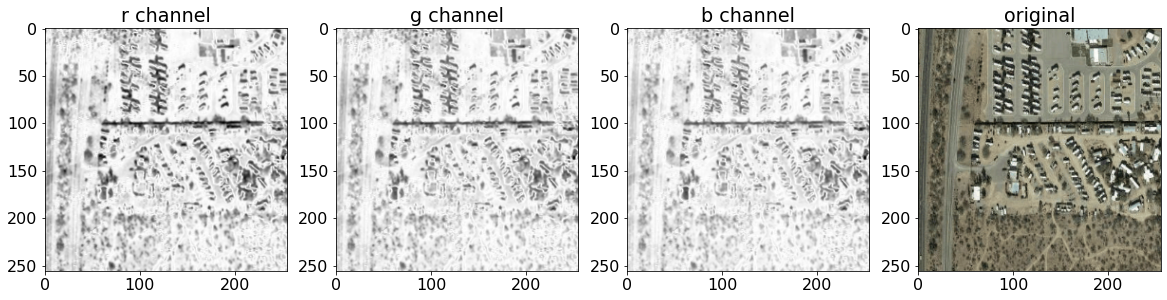

In [27]:
# test it
img_mod = test_plot(X_train_sobel_ds, original)

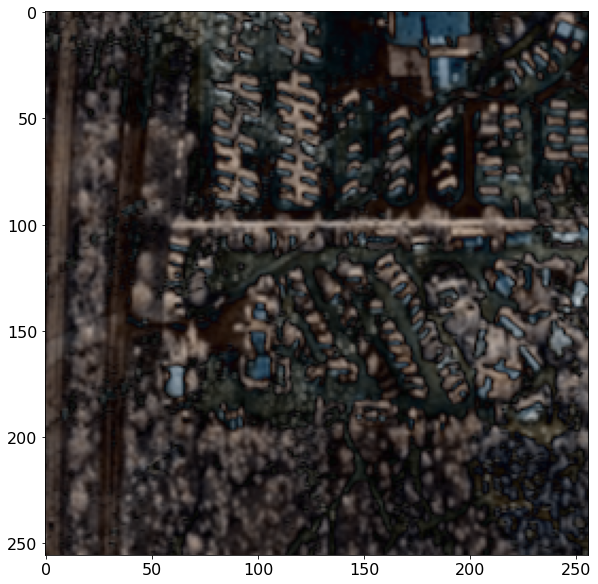

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.imshow(img_mod.numpy().astype('uint8'))

# or use the tf sobel_edges - this seems to work best!

In [20]:
def tf_sobel(image):
    '''
    test with an image dataset
    '''
    grad_components = sobel_edges(image)
    grad_mag_components = grad_components**2
    grad_mag_square = reduce_sum(grad_mag_components,axis=-1) # sum all magnitude components
    grad_mag_img = sqrt(grad_mag_square)
    grad_mag_img *= 255.0 / np.max(grad_mag_img)  # normalize (Q&D)
    return grad_mag_img

In [21]:
def tf_sobel_tf_ds(image, label):
    '''
    '''
    # define things for tf dataset
    im_shape = image.shape
    # do sobel
    [image,] = py_function(tf_sobel, [image], [float32])
    image.set_shape(im_shape)
    return image, label

In [24]:
X_train_tf_sobel_ds = X_train.map(tf_sobel_tf_ds)

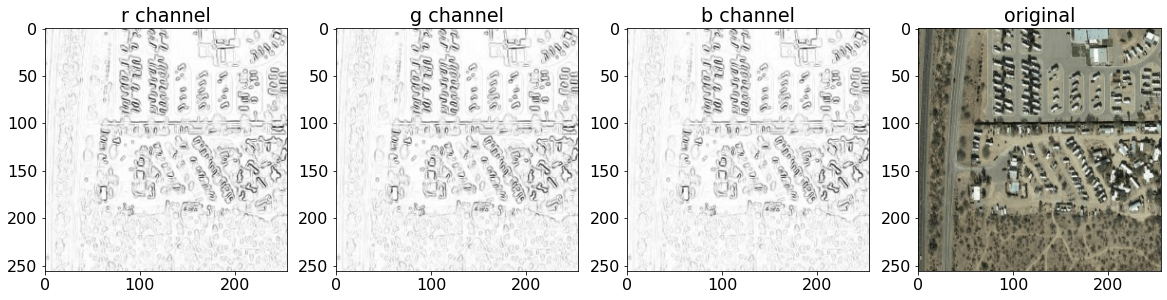

In [31]:
# test it
img_mod = test_plot(X_train_tf_sobel_ds, original)

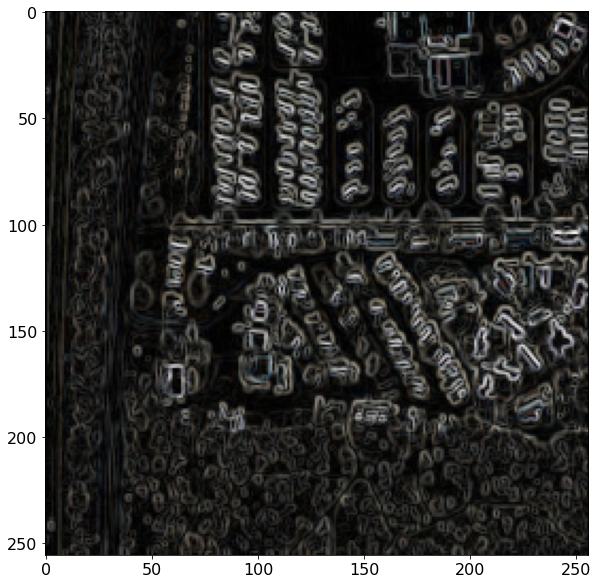

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.imshow(img_mod.numpy().astype('uint8'))

In [33]:
# try again with tf image gradients
def tf_img_gradients(image):
    '''
    test with an image dataset
    '''
    # returns tensors with same shape but with info on vert and hor grads
    dx, dy = image_gradients(image) # need to do separately for each channel?
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.max(mag)  # normalize (Q&D)
    # convert back to tensor
    mag_tf = convert_to_tensor(mag)
    return mag_tf

In [34]:
# for datasets
def tf_img_gradients_ds(image, label):
    '''
    '''
    # define things for tf dataset
    im_shape = image.shape
    [image,] = py_function(tf_img_gradients, [image], [float32])
    image.set_shape(im_shape)
    return image, label

In [35]:
# try it for the entire ds
X_train_grads = X_train.map(tf_img_gradients_ds)

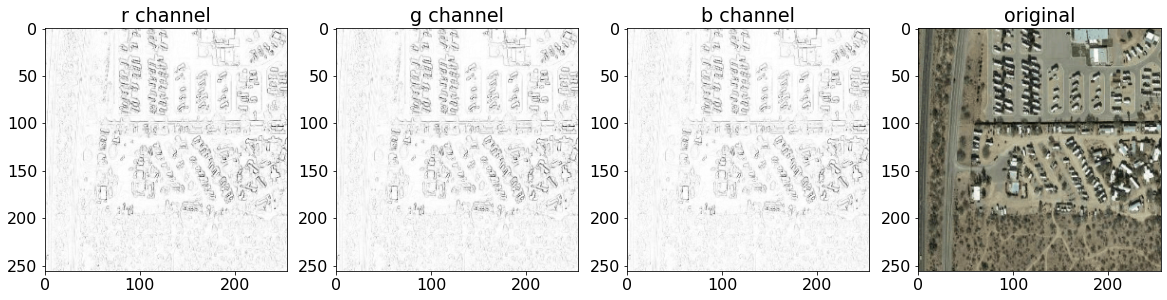

In [37]:
# test it
img_mod = test_plot(X_train_grads, original)

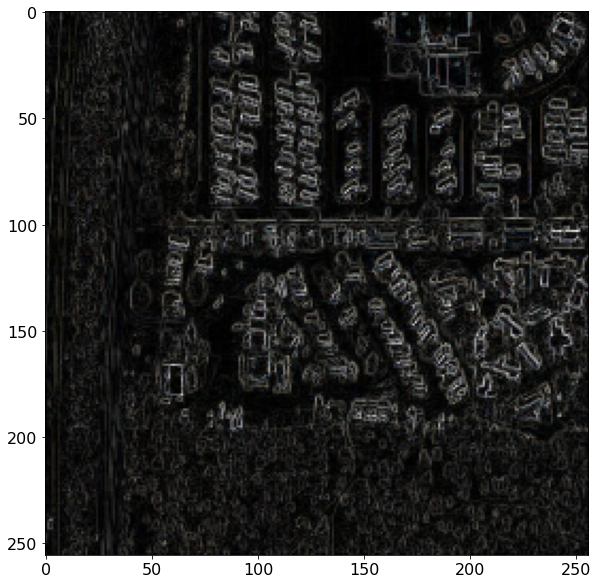

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.imshow(img_mod.numpy().astype('uint8'))